<header style="background:#00233C;padding-left:20pt;padding-right:20pt;padding-top:20pt;padding-bottom:10pt;"><img id="Teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 100px; height: auto; margin-top: 20pt;" align="right">
<p style="font-size:20px; color:#ffffff">UDW INNOVATION DAYS</p>
<p style="font-size:24px; color:#ffffff">KMeans</p>
</header>

### Use Case - Customers/Accounts/Transactions

Fictitious dataset of related customers (10K-ish rows), accounts (100K-ish rows), and Transactions (1M-ish rows). 
![Image](img/DemoData.png)

#### Load Packages

##### Install packages as needed
Note: You only need to run these once per package. The "!" allows you to run Linux script from the notebook cell. 

In [ ]:
!pip install teradataml --user

In [ ]:
!pip install matplotlib --user

In [ ]:
!pip install seaborn --user

#### Import teradataml package libraries

In [1]:
# managing connection context
from teradataml import create_context, get_context, remove_context

# for setting configure options
from teradataml import configure

# for teradataml DataFrame object
from teradataml.dataframe.dataframe import DataFrame, in_schema

# for copying pandas dataframe to SQL table
from teradataml.dataframe.copy_to import copy_to_sql

# dataframe manipulation methods and sql data types
from teradatasqlalchemy.types import *
from sqlalchemy.sql.expression import select, and_, or_, not_, extract, text, join, case as case_when
from sqlalchemy import func, sql, distinct

# teradataml utils
from teradataml import configure, db_drop_table, UtilFuncs

# Vantage Analytics Library (valib)
from teradataml.analytics.valib import *
from teradataml.analytics import Transformations as tf 

#### Import other helpful open source packages

In [2]:
# Open source packages

# hide passwords
import getpass as gp

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# system
from os.path import exists
import yaml, sys
from datetime import datetime as dt, timedelta
import math

# dataframes and matrices
import pandas as pd
import numpy as np

%matplotlib inline

##### Configure Display Options

In [3]:
plt.rcdefaults()
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (5, 3)
plt.rcParams['font.size'] = 8

### Connection Variables

##### Set User and Password Variables

In [ ]:
user = gp.getpass("User")

In [ ]:
password = gp.getpass("Password")

##### Set Connection Variables

In [4]:
host = 'UDWTest'
logmech = 'LDAP'
defaultDB = 'INOUDWTRAINING2024' 

##### Virtual DataFrames are only allowed in the MLA Databases.

If you are using a default database other than database="MLA_xxx", you must set the configure options below to your MLA database to use virtual DataFrames. 

**<font color="red">STOP: Only run cell below if default database is NOT MLA_XXX database.</font>**

In [ ]:
mlaDB = "MLA_XXX" # use your MLA database (MLA_BOPS, MLA_CNS, MLA_ENI, MLA_MNR)

# this is the MLA database to which teradataml virtual tables will be written. 
configure.temp_table_database = defaultDB if defaultDB[:3]=="MLA" else mlaDB

# this is the MLA database to which teradataml virtual views will be written.
configure.temp_view_database = defaultDB if defaultDB[:3]=="MLA" else mlaDB 

##### Create Context
See the PythonBasics-1-ConnectingToVantage Notebook for more information about contexts and garbage collection.  

In [6]:
td_context = create_context(host = host, 
                            username= user, 
                            password = password, 
                            logmech='LDAP', 
                            sslmode='ALLOW', 
                            database=defaultDB)

#### Set Vantage Analytics Library (VAL) database location

In [9]:
configure.val_install_location = "val" # schema in which the Vantage Analytics Library (VAL) is installed

### Customers DataFrame
Create a teradataml DataFrame object for the database table "demo_customers"

You only need to use `in_schema` if you are accessing non-default database table. 
Example: `customers = DataFrame(in_schema("some_other_db", "demo_customers"))`

In [10]:
customers = DataFrame("demo_customers")

##### View SQL behind teradataml DataFrame Object

In [11]:
customers.show_query()

'select * from "demo_customers"'

##### View the Teradata Data Types

In [12]:
customers.tdtypes

COLUMN NAME,TERADATA COLUMN TYPE
cust_id,INTEGER()
income,"DECIMAL(precision=16, scale=4)"
age,INTEGER()
years_with_bank,INTEGER()
nbr_children,INTEGER()
gender,"VARCHAR(length=64000, charset='LATIN')"
marital_status,INTEGER()
postal_code,"VARCHAR(length=64000, charset='LATIN')"
state_code,"VARCHAR(length=64000, charset='LATIN')"


##### View the Corresponding Pandas Data Types

In [13]:
customers.dtypes

COLUMN NAME,TERADATA COLUMN TYPE
cust_id,int
income,decimal.Decimal
age,int
years_with_bank,int
nbr_children,int
gender,str
marital_status,int
postal_code,str
state_code,str


### Exploratory Data Analysis (EDA) with VAL
We will do an exploratory data analysis using `teradataml.valib`, a Python teradataml library that provides access to the VAL functions in Vantage Advanced SQLE Database.

This section reviews descriptive statistics, overlap analysis, matrix analysis, and text field analysis.

#### Descriptive Statistics and Data Explorer

##### Data Explorer
- Values Analysis
- Univariate Statistical Analysis
- Frequencies (distribution analysis)
- Histograms (distribution analysis)

You can run each of the above individually, or use `valib.Explore()` to run them all to output -

`valib.Explore(data, columns=None, bins=10, bin_style='bins', max_comb_values=10000, max_unique_char_values=100, max_unique_num_values=20, min_comb_rows=25000, restrict_freq=True, restrict_threshold=1, statistical_method='population', stats_options=None, distinct=False, filter=None)`
1. frequency_output
2. histogram_output
3. statistics_output
4. values_output


##### Values
Use Values Analysis as the first type of analysis performed on unknown data.

`valib.Values(data, columns=None, exclude_columns=None, group_columns=None, distinct=False, filter=None)`

Example: Perform Values analysis on 'income' column with values grouped by 'gender' and only for rows with income greater than 50,000.

In [14]:
obj = valib.Values(data=customers, columns="income", group_columns="gender", filter="income > 50000")
obj.result

gender,xdb,xtbl,xcol,xtype,xcnt,xnull,xunique,xblank,xzero,xpos,xneg
M,MLA_BOPS,demo_customers,income,"DECIMAL(16,4)",1123.0,0.0,1114.0,None,0.0,1123.0,0.0
F,MLA_BOPS,demo_customers,income,"DECIMAL(16,4)",976.0,0.0,972.0,None,0.0,976.0,0.0


##### Convert result to pandas DataFrame to visualize

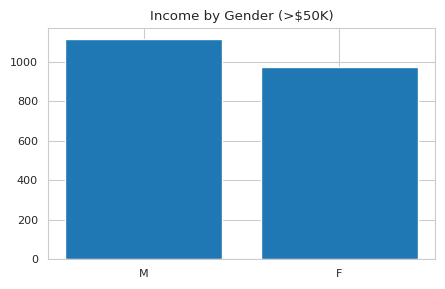

In [15]:
disp = obj.result.to_pandas(index_column='gender')
plt.title('Income by Gender (>$50K)')
plt.bar(x=disp.index, height=disp.xunique)
plt.show()

#### Statistics Analysis
Statistics Analysis provides several common and not so common statistical measures for numeric data columns. Extended options include Values, Modes, Quantiles, and Ranks.

`valib.Statistics(data, columns=None, exclude_columns=None, extended_options='none', group_columns=None, statistical_method='population', stats_options=None, filter=None)`

##### Example 1: Count, Min, Max, Mean, Std by Gender with Income > 0

In [16]:
obj = valib.Statistics(data=customers, columns="income", group_columns="gender", filter="income > 0")
obj.result

gender,xdb,xtbl,xcol,xcnt,xmin,xmax,xmean,xstd
F,MLA_BOPS,demo_customers,income,5054.0,297.4,265943.6,30380.10312623662,32773.18351861384
M,MLA_BOPS,demo_customers,income,3976.0,197.4,374808.2,40465.794567404475,45335.473545709654


##### Example 2: View Extended Options

In [17]:
obj = valib.Statistics(data=customers, columns="income", stats_options="all", extended_options="all")
obj.result

xdb,xtbl,xcol,xcnt,xmin,xmax,xmean,xstd,xskew,xkurt,xste,xcv,xvar,xsum,xuss,xcss,xtype,xnull,xnique,xblank,xzero,xpos,xneg,xmode,xmode_cnt,xmode_pct,xnbrmodes,xpctile0,xpctile1,xpctile2,xpctile3,xpctile4,xpctile5,xpctile6,xpctile7,xpctile8,xpctile9,xpctile10,xpctile20,xpctile25,xpctile30,xpctile33,xpctile40,xpctile50,xpctile60,xpctile67,xpctile70,xpctile75,xpctile80,xpctile90,xpctile91,xpctile92,xpctile93,xpctile94,xpctile95,xpctile96,xpctile97,xpctile98,xpctile99,xpctile100,xmin_1,xmin_2,xmin_3,xmin_4,xmin_5,xmincnt_1,xmincnt_2,xmincnt_3,xmincnt_4,xmincnt_5,xmax_5,xmax_4,xmax_3,xmax_2,xmax_1,xmaxcnt_5,xmaxcnt_4,xmaxcnt_3,xmaxcnt_2,xmaxcnt_1
MLA_BOPS,demo_customers,income,10458.0,0.0,374808.2,30066.268923312342,38276.21579485959,2.511662554570656,9.349901859594745,374.28694182240235,127.30617121960731,1465068695.5746589,314433040.40000045,24775516769360.93,15321688418319.783,"DECIMAL(16,4)",0.0,8253.0,None,1428.0,9030.0,0.0,0.0,1428.0,13.654618473895582,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2564.4,4155.7,5918.0,7078.3,10443.5,16611.0,24582.6,31458.0,35016.8,41778.0,50180.0,77322.0,81034.8,85820.0,91304.2,98467.6,105084.0,114388.0,127848.0,146716.2,180874.4,374808.2,0.0,197.4,218.2,297.4,302.3,1428.0,1.0,2.0,1.0,1.0,331561.1,332404.8,335909.6,369912.4,374808.2,1.0,1.0,1.0,1.0,1.0


#### Frequency

Frequency Analysis counts the occurrences of individual data values in columns that contain categorical data.

`Frequency(data, columns=None, exclude_columns=None, cumulative_option=False, agg_filter=None, min_percentage=None, pairwise_columns=None, stats_columns=None, style='basic', top_n=None, filter=None)`

##### Example: Perform Frequency Analysis on age with cumulative option

In [18]:
obj = valib.Frequency(data=customers, columns="age", cumulative_option=True)
obj.result.sort('xval')

xtbl,xcol,xval,xcnt,xpct,xcum_cnt,xcum_pct,xcum_rank
demo_customers,age,10,15.0,0.1434308663224326,10406.0,99.50277299674892,81.0
demo_customers,age,11,32.0,0.30598584815452284,10239.0,97.9059093516925,74.0
demo_customers,age,12,19.0,0.18167909734174795,10374.0,99.1967871485944,79.0
demo_customers,age,13,66.0,0.6310958118187033,9546.0,91.2794033275961,60.0
demo_customers,age,14,110.0,1.0518263530311722,8611.0,82.33887932683113,50.0
demo_customers,age,15,188.0,1.7976668579078217,3355.0,32.08070376745076,16.0
demo_customers,age,16,199.0,1.902849493210939,2204.0,21.074775291642762,10.0
demo_customers,age,17,203.0,1.9410977242302543,1603.0,15.327978580990628,7.0
demo_customers,age,18,261.0,2.495697074010327,261.0,2.495697074010327,1.0
demo_customers,age,19,240.0,2.2948938611589216,749.0,7.161981258366801,3.0


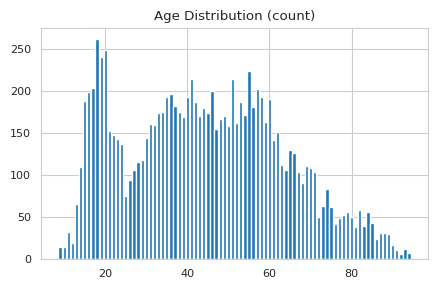

In [19]:
disp = obj.result.to_pandas(index_column='xval')
disp = disp.sort_values('xval')
plt.title('Age Distribution (count)')
plt.bar(x=disp.index.astype(int), height=disp.xcnt)
plt.show()

#### Histogram
Histogram Analysis reveals the distribution of continuous numeric or date values in a column.

`Histogram(data, columns=None, bins=10, bins_with_boundaries=None, boundaries=None, quantiles=10, widths=None, exclude_columns=None, overlay_columns=None, stats_columns=None, hist_style='basic', filter=None)`

##### Example: Perform histogram analysis on income > 0 and overlay with gender.

In [20]:
obj = valib.Histogram(data=customers, columns=["income"], overlay_columns="gender", filter="income > 0")
obj.result.sort(['xbin','ovly_gender'], ascending=False)

xdb,xtbl,xcol,xbin,xbeg,xend,xcnt,xpct,ovly_gender,xocnt,xobpct,xopct
MLA_BOPS,demo_customers,income,10,337347.12,374808.2,2.0,0.0221483942414175,M,2.0,100.0,0.0221483942414175
MLA_BOPS,demo_customers,income,9,299886.04,337347.12,6.0,0.0664451827242525,M,6.0,100.0,0.0664451827242525
MLA_BOPS,demo_customers,income,8,262424.96,299886.04,9.0,0.09966777408637874,M,7.0,77.77777777777777,0.07751937984496124
MLA_BOPS,demo_customers,income,8,262424.96,299886.04,9.0,0.09966777408637874,F,2.0,22.22222222222222,0.0221483942414175
MLA_BOPS,demo_customers,income,7,224963.88,262424.96,19.0,0.21040974529346623,M,14.0,73.6842105263158,0.15503875968992248
MLA_BOPS,demo_customers,income,7,224963.88,262424.96,19.0,0.21040974529346623,F,5.0,26.31578947368421,0.05537098560354374
MLA_BOPS,demo_customers,income,6,187502.8,224963.88,54.0,0.5980066445182725,M,41.0,75.92592592592592,0.4540420819490587
MLA_BOPS,demo_customers,income,6,187502.8,224963.88,54.0,0.5980066445182725,F,13.0,24.074074074074073,0.14396456256921372
MLA_BOPS,demo_customers,income,5,150041.72,187502.8,106.0,1.1738648947951273,M,67.0,63.20754716981132,0.7419712070874862
MLA_BOPS,demo_customers,income,5,150041.72,187502.8,106.0,1.1738648947951273,F,39.0,36.79245283018868,0.4318936877076412


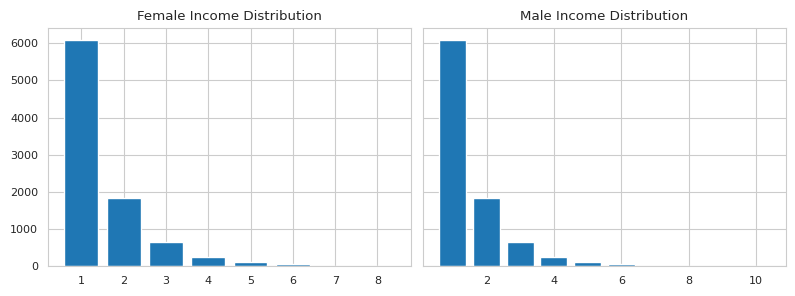

In [21]:
n_bins=10
disp_f = obj.result[obj.result.ovly_gender=='F'].to_pandas(index_column=['xbin'])
disp_f = disp_f.sort_values('xbin')
disp_m = obj.result[obj.result.ovly_gender=='M'].to_pandas(index_column=['xbin'])
disp_m = disp_m.sort_values('xbin')
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=([8,3]))
axs[0].bar(x=disp_f.index.astype(int), height=disp_f.xcnt)
axs[0].set_title('Female Income Distribution')
axs[1].bar(x=disp_m.index.astype(int), height=disp_m.xcnt)
axs[1].set_title('Male Income Distribution')
plt.show()

#### Adaptive Histogram

Adaptive Histogram analysis supplements Histogram analysis by offering options to further subdivide the distribution. 

`valib.AdaptiveHistogram(data, columns=None, bins=10, exclude_columns=None, spike_threshold=10, subdivision_method='means', subdivision_threshold=30, filter=None)`

##### Example:  Shows execution with 10 equal width bins created by default for income.
The default value of 10 is used for "spike_threshold", and 30 for "subdivision_threshold", with means as the default "subdivision_method"

Note:  Without adaptive binning, spike values and/or overpopulated bins can distort the bin counts, as they are not separated or subdivided unless the Adaptive Histogram function is used.

In [22]:
obj = valib.AdaptiveHistogram(data=customers, columns="income")
obj.result

xtbl,xcol,xbeg,xend,xtype,xdesc,xcnt,xpct
demo_customers,income,14340.548507217838,16417.914448483483,3,**bin,320.0,3.0598584815452283
demo_customers,income,37658.48,75119.56,1,bin,1838.0,17.575062153375406
demo_customers,income,22650.012272280423,24727.378213546068,3,**bin,237.0,2.266207687894435
demo_customers,income,197.4,37658.48,1,bin,6096.0,58.2903040734366
demo_customers,income,3953.7188008896096,6031.084742155255,3,**bin,626.0,5.985848154522853
demo_customers,income,262424.96,299886.04000000004,1,bin,9.0,0.08605851979345955
demo_customers,income,6031.084742155255,8108.450683420901,3,**bin,505.0,4.828839166188564
demo_customers,income,0.0,0.0,0,spike,1428.0,13.654618473895582
demo_customers,income,150041.72,187502.80000000002,1,bin,106.0,1.013578122011857
demo_customers,income,24727.378213546068,26420.156000000003,2,--bin,182.0,1.7402945113788488


#### Overlap Analysis

Compare different tables for Index/Key column Consistency/Overlaps

`valib.Overlap(data1, columns1, **kwargs)`

Example: Perform Overlap analysis between customers and accounts on cust_id

In [23]:
accounts = DataFrame("demo_accounts")
accounts.head(5)

acct_nbr,cust_id,acct_type,account_active,acct_start_date,starting_balance,ending_balance
000000001362480212,16349760,CK,Y,1992-12-23 00:00:00.000000,398.220,182.406
000000001362480214,19074720,CK,Y,1992-12-23 00:00:00.000000,464.590,356.126
000000001362480213,17712240,CK,Y,1992-12-23 00:00:00.000000,2024.285,193.698
000000001362480211,14987280,CK,Y,1992-12-23 00:00:00.000000,630.515,425.614
000000001362480210,13624800,CK,Y,1992-12-23 00:00:00.000000,630.515,390.870


In [24]:
overlap_obj = valib.Overlap(data1=customers,
                                data2=accounts,
                                columns1=["cust_id"],
                                columns2="cust_id")
overlap_obj.result

xidx,xdb,xtbl,xcol,xcnt,xunique,demo_customers,demo_accounts
2,MLA_BOPS,demo_accounts,cust_id,19726.0,9310.0,None,None
1,MLA_BOPS,demo_customers,cust_id,10458.0,10458.0,None,0.0


#### Text Analyzer

The TextAnalyzer function analyzes character data and distinguishes if the field is a numeric type, date, time, timestamp, or character data and returns two output DataFrames - 
1. analysis results
2. column data type matrix having the progression of data type through the series of steps 

In [25]:
obj = valib.TextAnalyzer(data=customers, columns="all")
obj.result

cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,postal_code,state_code
14989601,28765.000,48,7,3,M,2,89194,NV
27253820,52300.000,46,7,1,M,2,89194,NV
16360284,3998.600,41,11,6,M,2,94180,CA
25897247,842.600,70,7,0,F,2,10101,NY
21804320,199916.600,42,5,1,F,1,19126,PA
25891680,3573.100,24,6,0,M,1,60665,IL
19084968,12670.000,66,6,1,F,2,44127,OH
29982260,24052.600,23,8,0,F,1,15279,PA
24534252,27718.200,62,0,2,M,2,10101,NY
27263480,42768.000,58,9,1,F,2,92817,CA


In [26]:
obj.data_type_matrix

Column Name,Initial Database Type,Min Max Type,Sample Type,Numeric Test Type,Translatable To Latin,Total Unicode Count
gender,VARCHAR(64000) CHARACTER SET LATIN,VARCHAR(1),VARCHAR(1),VARCHAR(1),NA,NA
nbr_children,INTEGER FORMAT '-(10)9',NA,NA,NA,NA,NA
years_with_bank,INTEGER FORMAT '-(10)9',NA,NA,NA,NA,NA
postal_code,VARCHAR(64000) CHARACTER SET LATIN,INTEGER,INTEGER,INTEGER,NA,NA
income,"DECIMAL(16,4) FORMAT '-------------.9999'",NA,NA,NA,NA,NA
age,INTEGER FORMAT '-(10)9',NA,NA,NA,NA,NA
state_code,VARCHAR(64000) CHARACTER SET LATIN,VARCHAR(2),VARCHAR(2),VARCHAR(2),NA,NA
marital_status,INTEGER FORMAT '-(10)9',NA,NA,NA,NA,NA
cust_id,INTEGER FORMAT '-(10)9',NA,NA,NA,NA,NA


#### Matrix Building

Use as input to linear regression or to analyze matrices such as sum-of-squares and cross-products, covariance, and correlation.

- ESSCP = Extended-sum-of-squares-and-cross-products matrix (default)
- SSCP = sum-of-squares-and-cross-products matrix 
- CSSCP = Corrected-sum-of-squares-and-cross-products matrix
- COV = Covariance matrix
- COR = Correlation matrix

`valib.Matrix(data, columns=None, exclude_columns=None, group_columns=None, matrix_output='columns', type='ESSCCP', handle_nulls='IGNORE', filter=None)`

##### Example 1: Build a 3-by-3 ESSCP matrix on input columns 'age', 'years_with_bank', and 'nbr_children'.

In [ ]:
obj = valib.Matrix(data=customers, columns=["age", "years_with_bank", "nbr_children"])
obj.result

##### Example 2: Build a 3-by-3 COR matrix by limiting the input data by filtering rows. Matrix is built on input columns 'age', 'years_with_bank', and 'nbr_children'.

In [ ]:
obj = valib.Matrix(data=customers,
                   columns=["age", "years_with_bank", "nbr_children"], 
                   filter="nbr_children > 1",
                   type="COR")
obj.result

#### Variable Transformations
The Variable Transformation analysis reads a single table or view and produces a Select, Create Table, or
Create View statement containing transformed columns. This is useful when preparing data for input to an
analytic algorithm. 

Function supports following transformations:
- **Binning** - Binning replaces a continuous numeric column with a categorical one to produce ordinal values.
- **Derive** - The Derive transformation requires the free-form transformation be specified as a formula.
- **One Hot Encoding** - One Hot Encoding is useful when a categorical data element must be re-expressed as one or more numeric data elements, creating a binary numeric field for each categorical data value.
- **Missing Value** Treatment or Null Replacement.
- **Label Encoding** - Allows to re-express existing values of a categorical data column (variable) into a new coding scheme or to correct data quality problems and focus an analysis on a value.
- **Min-Max Scaling** - Limits the upper and lower boundaries of the data in a continuous numeric column using a linear rescaling function based on maximum and minimum data values.
- **Retain** - Allows copying of one or more columns into the final analytic data set.
- **Sigmoid** - Provides rescaling of continuous numeric data using a type of sigmoid or s-shaped function.
- **ZScore** - Provides rescaling of continuous numeric data using Z-Scores.

`Transform(data, bins=None, derive=None, one_hot_encode=None, fillna=None, label_encode=None, rescale=None, retain=None, sigmoid=None, zscore=None, fallback=False, index_columns=None, unique_index=False, key_columns=None, allow_duplicates=None, nopi=None, filter=None)`

##### Binning performed on column "income" with different number of bins.

In [ ]:
bin_1 = Binning(style="bins", value=3, columns="income", out_columns="inc1")
bin_2 = Binning(style="bins", value=4, columns="income", out_columns="inc2")
bin_3 = Binning(style="bins", value=5, columns="income", out_columns="inc3")

##### Derive transformation done on "age" column with different arithmetic formula.

In [ ]:
derive_1 = Derive(formula="x/10", columns="age", out_column="age1")
derive_2 = Derive(formula="x*10", columns="age", out_column="age2")
derive_3 = Derive(formula="x+10", columns="age", out_column="age3") 

##### One hot encoding done for values in columns "gender" and "marital_status".

In [ ]:
dc_1 = OneHotEncoder(values=["M", "F"], columns="gender")
dc_2 = OneHotEncoder(values=[1, 2, 3, 4], columns="marital_status")

##### Replace null values in column "income", by using 'mean' null style.

In [ ]:
fn_1 = FillNa(columns="income", out_columns="income_x")

##### Values in column "age" are rescaled using MinMaxScalar using
1. Both lower bound and upper bound,
2. Only lower bound,
3. Only upper bound.

In [ ]:
rs_1 = MinMaxScalar(lbound=0, ubound=100, columns="age", out_columns="age4")
rs_2 = MinMaxScalar(lbound=0, ubound=None, columns="age", out_columns="age5")
rs_3 = MinMaxScalar(lbound=None, ubound=100, columns="age", out_columns="age6") 

##### Rescale values in column "nbr_children" using various sigmoid functions.

In [ ]:
sig_1 = Sigmoid(style="logit", columns="nbr_children", out_columns="nbr1")
sig_2 = Sigmoid(style="modifiedlogit", columns="nbr_children", out_columns="nbr2")
sig_3 = Sigmoid(style="tanh", columns="nbr_children", out_columns="nbr3")

##### Rescale values in column "years_with_bank" using Z-Score values.

In [ ]:
zscore = ZScore(columns="years_with_bank", out_columns="ywb") 

##### Retain columns "income", "age", "years_with_bank" and "nbr_children" in the transformed output.

In [ ]:
retain = Retain(columns=["income", "age", "years_with_bank", "nbr_children"])

#### Apply all transformations at once

In [ ]:
obj = valib.Transform(data=customers, 
                      bins=[bin_1, bin_2, bin_3],
                      derive=[derive_1, derive_2, derive_3],
                      one_hot_encode=[dc_1, dc_2],
                      fillna=[fn_1],
                      rescale=[rs_1, rs_2, rs_3],
                      retain=retain,
                      sigmoid=[sig_1, sig_2, sig_3],
                      zscore=zscore,
                      key_columns="cust_id")

In [ ]:
obj.result

### Remove context
This best practice performs garbage collection for the volatile tables and views that were created during this session.

In [ ]:
# One must run remove_context() to close the connection and garbage collect internally generated objects.
remove_context()

<span style="font-size:16px;">For online documentation on Teradata Vantage analytic functions, refer to the [Teradata Developer Portal](https://docs.teradata.com/) and search for phrases "Python User Guide" and "Python Function Reference".</span>